## 4.1多层感知机

### 4.1.1隐藏层

    加入激活函数实现从线性到非线性

### 4.1.2 激活函数

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

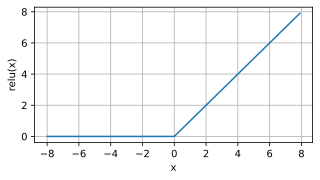

In [2]:
x = torch.arange(-8, 8, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

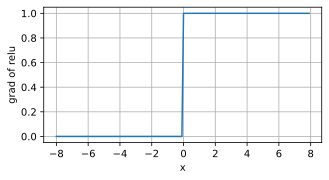

In [3]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

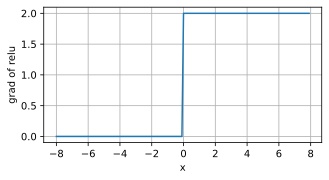

In [4]:
y.sum().backward()
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

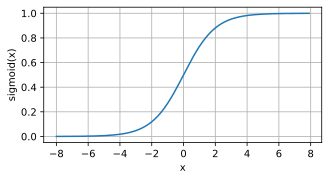

In [5]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

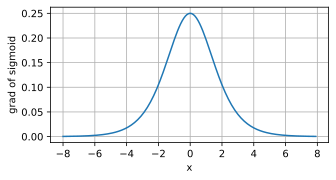

In [6]:
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

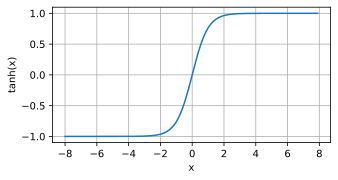

In [7]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

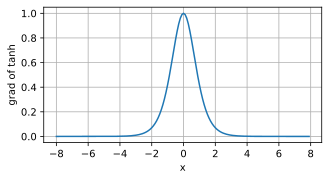

In [8]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

## 4.2 多层感知机的从零开始实现

In [9]:
import torch
from torch import nn
from d2l import torch as d2l

In [10]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### 4.2.1 初始化模型参数

In [11]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))
params = [W1, b1, W2, b2]

### 4.2.2激活函数

In [12]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

### 4.2.3模型

In [13]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)
    return (H@W2 + b2)

### 4.2.4损失函数

In [14]:
loss = nn.CrossEntropyLoss()

### 4.2.5训练

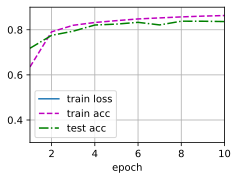

In [15]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

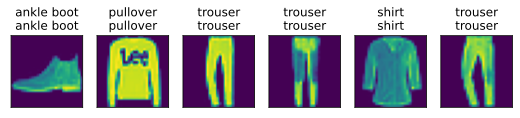

In [16]:
d2l.predict_ch3(net, test_iter)

## 4.3多层感知机的简洁实现

In [17]:
import torch
from torch import nn
from d2l import torch as d2l

### 4.3.1 模型

In [18]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

In [19]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)

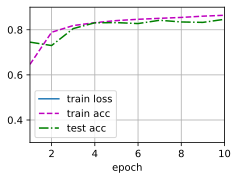

In [20]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 4.4 模型选择、欠拟合和过拟合

### 4.4.1 训练误差和泛化误差

### 4.4.4 多项式回归

In [21]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

    生成三阶多项式加噪声

In [22]:
max_degree = 20 # 多项式的最⼤阶数
n_train, n_test = 100, 100 # 训练和测试数据集⼤⼩
true_w = np.zeros(max_degree) # 分配⼤量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])
features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [23]:
# NumPyndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
torch.float32) for x in [true_w, features, poly_features, labels]]

In [24]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.2356],
         [ 1.0328]]),
 tensor([[ 1.0000e+00, -1.2356e+00,  7.6340e-01, -3.1443e-01,  9.7129e-02,
          -2.4003e-02,  4.9432e-03, -8.7257e-04,  1.3477e-04, -1.8503e-05,
           2.2863e-06, -2.5682e-07,  2.6445e-08, -2.5136e-09,  2.2185e-10,
          -1.8275e-11,  1.4113e-12, -1.0258e-13,  7.0418e-15, -4.5795e-16],
         [ 1.0000e+00,  1.0328e+00,  5.3335e-01,  1.8362e-01,  4.7410e-02,
           9.7931e-03,  1.6857e-03,  2.4872e-04,  3.2110e-05,  3.6849e-06,
           3.8058e-07,  3.5733e-08,  3.0754e-09,  2.4433e-10,  1.8025e-11,
           1.2411e-12,  8.0114e-14,  4.8672e-15,  2.7927e-16,  1.5181e-17]]),
 tensor([-0.8275,  5.2089]))

In [25]:
def evaluate_loss(net, data_iter, loss): #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2) # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [26]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=1000):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

    三阶多项式函数拟合

weight: [[ 4.9898186  1.1845747 -3.397521   5.613561 ]]


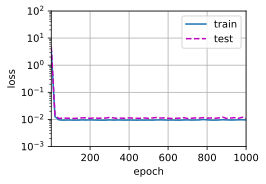

In [27]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

    线性函数拟合

weight: [[2.8281386 4.086416 ]]


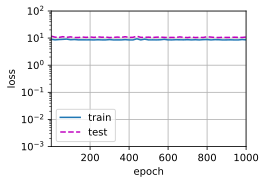

In [28]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
    labels[:n_train], labels[n_train:])

    ⾼阶多项式函数拟合

weight: [[ 4.980144    1.1918304  -3.3757017   5.5790477  -0.09958961  0.1201336
   0.20377858 -0.05180537  0.04664829 -0.15298544  0.17614394 -0.02133632
   0.07429568 -0.16800433 -0.02963807  0.20318545  0.12330005 -0.14395638
   0.11242091 -0.18108198]]


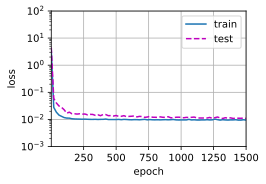

In [29]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

## 4.5权重衰减

### 4.5.2高维线性回归

In [30]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

    200维小数据集样本

In [31]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

### 4.5.3从零开始实现

In [32]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [33]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [34]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # ⼴播机制使l2_penalty(w)成为⼀个⻓度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                         d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是： ', torch.norm(w).item())

w的L2范数是：  13.69122314453125


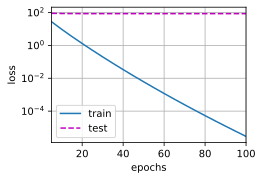

In [35]:
train(lambd=0) 

w的L2范数是：  0.3838248550891876


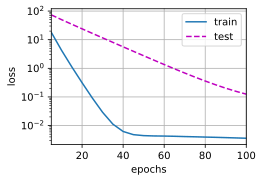

In [36]:
train(lambd=3)

### 4.5.4简介实现

In [37]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                         d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数： ', net[0].weight.norm().item())

w的L2范数：  14.200289726257324


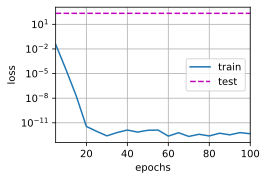

In [38]:
train_concise(0)

w的L2范数：  0.12326251715421677


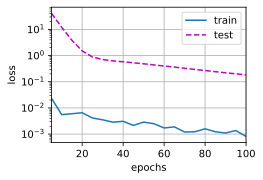

In [39]:
train_concise(10)

### 4.6 Dropout

### 4.6.4从零开始实现

In [40]:
import torch
from torch import nn
from d2l import torch as d2l

In [41]:
def dropout_layer(X, dropout):
    assert 0 <=dropout <=1
    if dropout == 1:
        return torch.zeros_like(X)
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    # print(mask)
    return mask * X / (1.0 - dropout)

In [42]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))

print(dropout_layer(X, 0.5))


tensor([[ 0.,  0.,  4.,  0.,  8., 10.,  0.,  0.],
        [16., 18.,  0., 22., 24.,  0., 28., 30.]])


    定义模型

In [43]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

In [44]:
dropout1, dropout2 = 0.2, 0.5
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
    
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使⽤dropout
        if self.training == True:
            # 在第⼀个全连接层之后添加⼀个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第⼆个全连接层之后添加⼀个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

    训练和测试

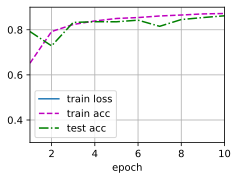

In [45]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 4.6.5简洁实现

In [46]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Dropout(dropout1),
                    nn.Linear(256, 256),
                    nn.ReLU(),
                    nn.Dropout(dropout2),
                    nn.Linear(256, 10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

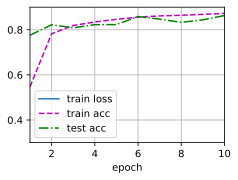

In [47]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 4.8 数值稳定性和梯度爆炸

### 4.8.1梯度爆炸和梯度消失

In [48]:
%matplotlib inline
import torch
from d2l import torch as d2l

    梯度消失

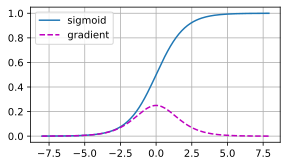

In [49]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))
d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

    梯度爆炸

In [50]:
M = torch.normal(0, 1, size=(4,4))
print('⼀个矩阵 \n',M)
for i in range(100):
    M = torch.mm(M,torch.normal(0, 1, size=(4, 4)))
print('乘以100个矩阵后\n', M)

⼀个矩阵 
 tensor([[-0.3425, -0.2097, -0.8047, -0.6319],
        [-0.0598, -0.4397, -0.0048, -1.2200],
        [ 0.3601,  1.7363,  0.3352, -1.0837],
        [-0.2287,  1.3535, -0.4942,  1.7785]])
乘以100个矩阵后
 tensor([[ 2.7603e+23, -1.0979e+23, -2.8429e+21,  1.2260e+23],
        [ 7.3266e+23, -2.9143e+23, -7.5471e+21,  3.2541e+23],
        [ 5.2422e+23, -2.0852e+23, -5.4003e+21,  2.3283e+23],
        [-1.2721e+24,  5.0601e+23,  1.3103e+22, -5.6502e+23]])


## 4.10 预测房价

### 4.10.1下载和缓存数据集

In [51]:
import hashlib
import os
import tarfile
import zipfile
import requests
#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [52]:
def download(name, cache_dir=os.path.join('..', 'data')): #@save
    """下载⼀个DATA_HUB中的⽂件，返回本地⽂件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [53]:
def download_extract(name, folder=None): #@save
    """下载并解压zip/tar⽂件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar⽂件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all(): #@save
    """下载DATA_HUB中的所有⽂件"""
    for name in DATA_HUB:
        download(name)

### 4.10.3访问和读取数据集

In [54]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [55]:
DATA_HUB['kaggle_house_train'] = ( #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = ( #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [56]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载../data/kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载../data/kaggle_house_pred_test.csv...


In [57]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [58]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [59]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

### 4.10.4数据预处理

In [60]:
# 若⽆法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [61]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指⽰符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [62]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

### 4.10.5 训练

In [63]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [64]:
def log_rmse(net, features, labels):
    # 为了在取对数时进⼀步稳定该值，将⼩于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                        torch.log(labels)))
    return rmse.item()

In [65]:
def train(net, train_features, train_labels, test_features, test_labels,
            num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这⾥使⽤的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

### 4.10.6 K折交叉验证

In [66]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [67]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
            batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                    weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                        xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                        legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
                f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

### 4.10.7 模型选择

折1，训练log rmse0.170255, 验证log rmse0.156931
折2，训练log rmse0.162161, 验证log rmse0.189466
折3，训练log rmse0.163693, 验证log rmse0.168273
折4，训练log rmse0.167486, 验证log rmse0.154443
折5，训练log rmse0.163448, 验证log rmse0.183090
5-折验证: 平均训练log rmse: 0.165408, 平均验证log rmse: 0.170441


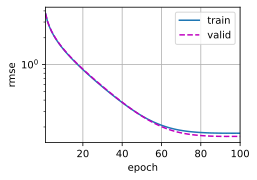

In [68]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
        f'平均验证log rmse: {float(valid_l):f}')